# Regression with MLPs
In this lesson we will see how an MLP model can learn to predict the value of a function in a given point. In particular, we will see how the model gradually learns to approximate the function and what are the limits of generalization of such a model.

If you already have no done it, [try running this Test jupyter notebook](https://github.com/LucaCappelletti94/bioinformatics_practice/blob/master/Notebooks/Testing%20that%20everything%20works.ipynb) and check that everything does work nominally.

To run this jupyter you will need to have installed packages such as [sklearn](https://scikit-learn.org/stable/index.html) and [numpy](https://docs.scipy.org/doc/numpy/user/index.html), so to get started just run the following:

```bash
pip install numpy sklearn matplotlib
```

In [1]:
# We import these packages using the standard notations
import numpy as np
import matplotlib.pyplot as plt

## Choosing a function to approximate
In this tutorial we get to choose a function that we will try to approximate. I will choose a combination of trigonometric functions, and I will pretend this is a signal that [I have received from some device](https://www.youtube.com/watch?v=AvUbqY1S-QQ).

Side note: I will use [type hinting](https://www.python.org/dev/peps/pep-0484/) to clarify what comes in and out of a function, but it is just a form on documentation. It does not do anything if not signal an IDE what the function has to receive and return.

In [2]:
def signal(x:np.ndarray)->np.ndarray:
    """An alien signal."""
    return np.sin(x) + np.sign(x)*np.log(1+np.abs(x/np.sqrt(1+np.abs(x))))

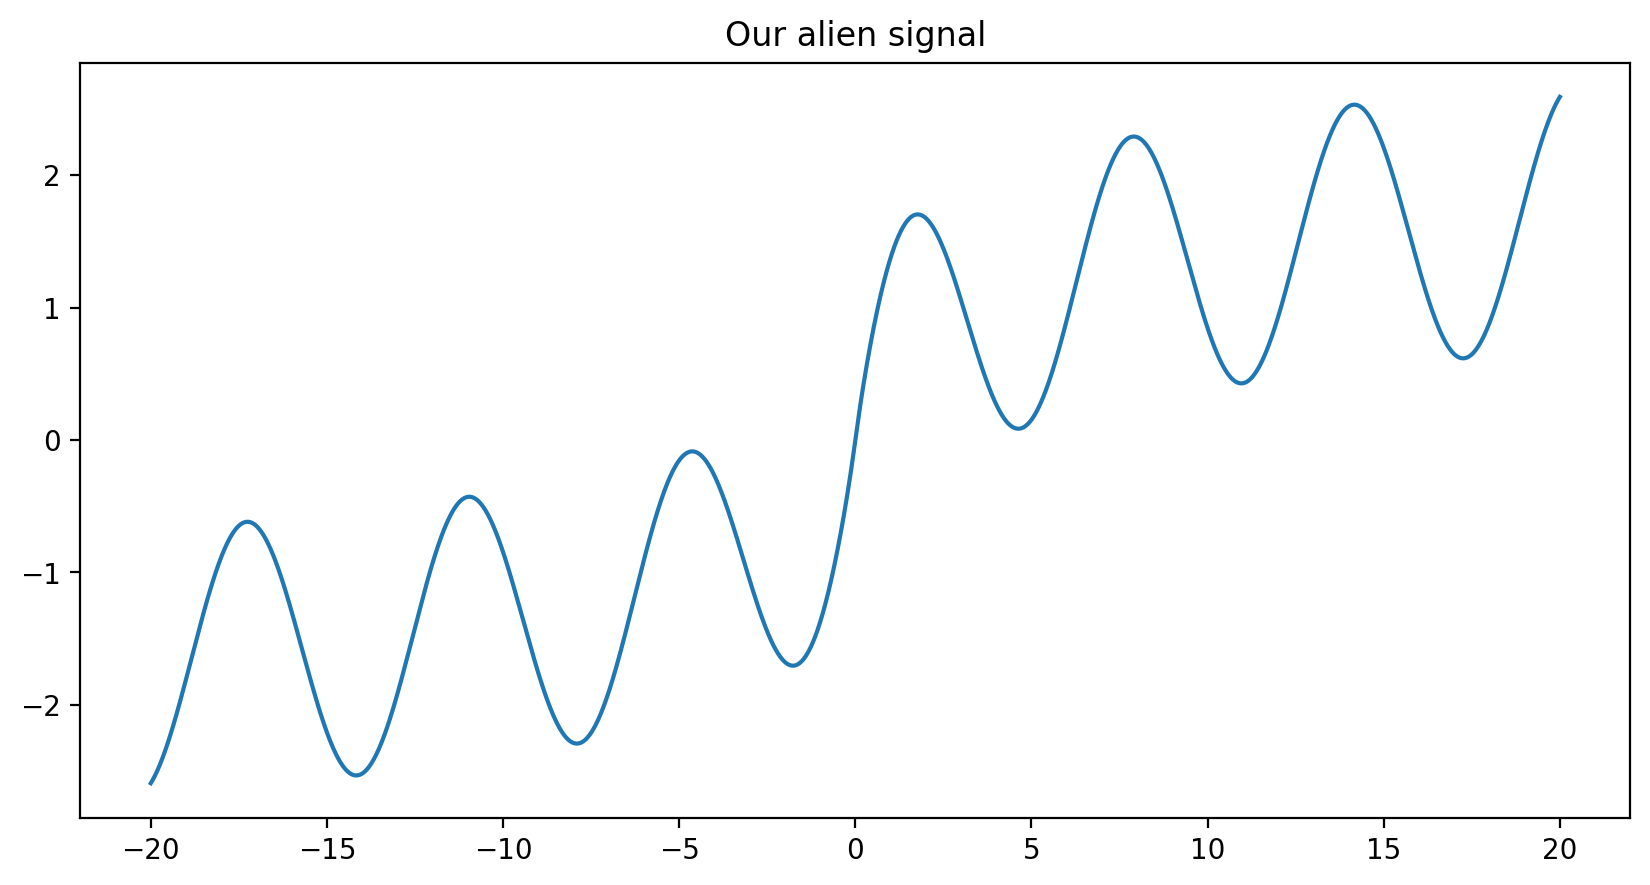

In [3]:
# Plotting the function
interval = 20
x = np.linspace(-interval, interval, num=10000)
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x, signal(x))
plt.title("Our alien signal")
plt.show()

## Sampling a signal
Now, if we were to posess the original analytical signal (we do but we are pretending to not have it) it would be quite useless to try and build a model to predict it. In a real scenario, our device cannot pick up a continuos signal, but only an discrete approximation of the signal.

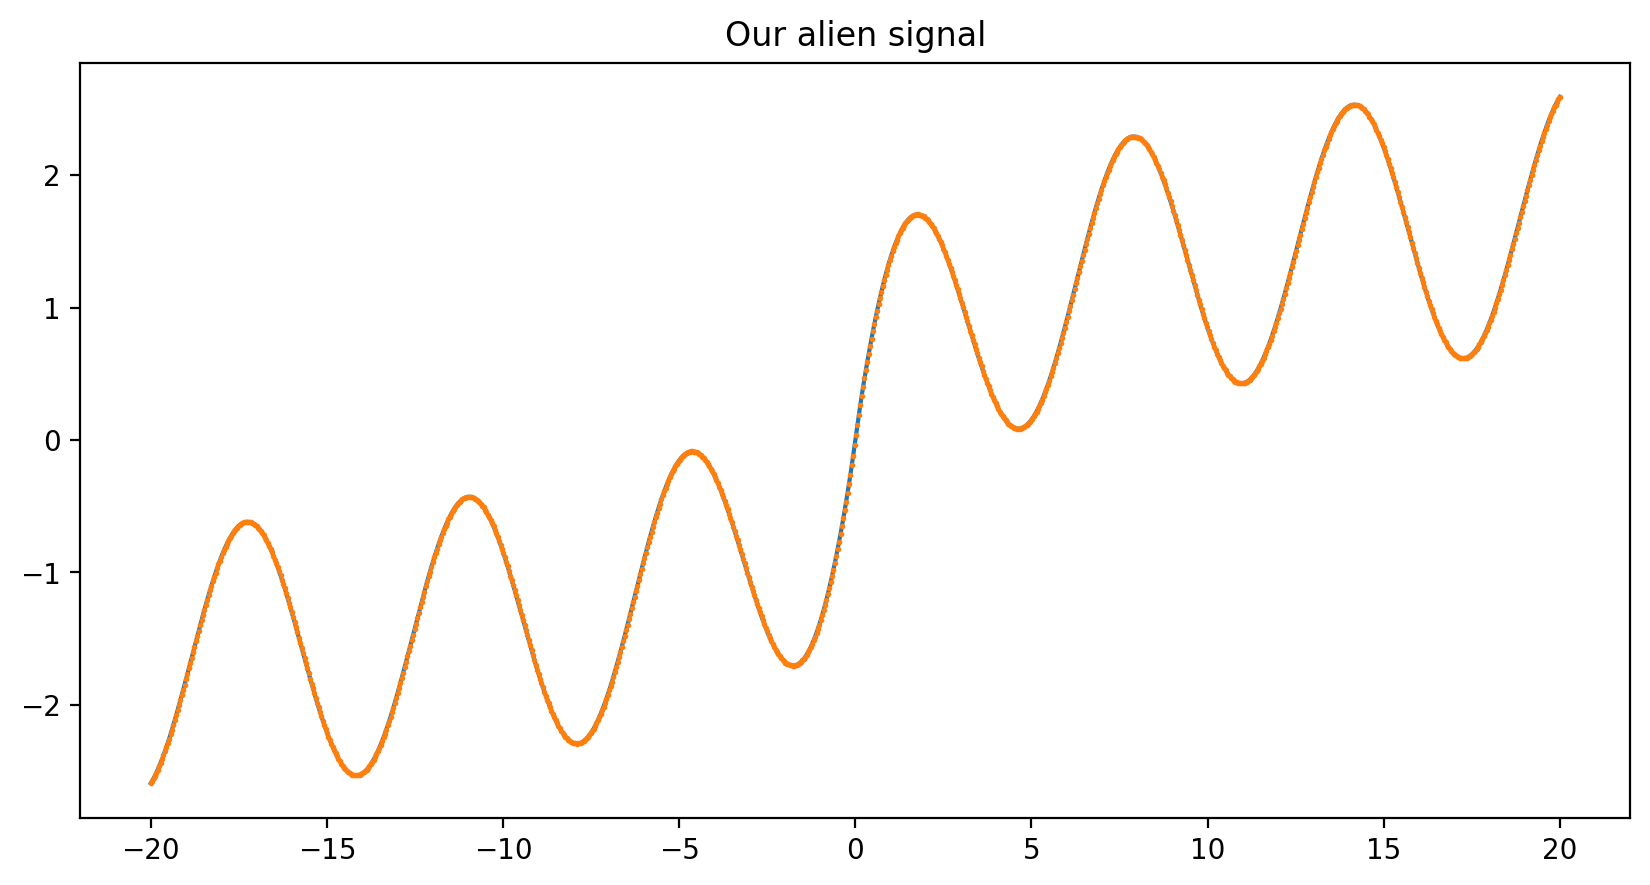

In [4]:
# Plotting the function
real_signal = np.linspace(-interval, interval, num=10000)
received_signal = np.linspace(-interval, interval, num=1000)
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(real_signal, signal(real_signal))
plt.plot(received_signal, signal(received_signal), '.', markersize=2)
plt.title("Our alien signal")
plt.show()

## Building a training and test dataset
To determine if a model is actually learning something usefull and not creating an hashmap of the values we need to create a proper training and testing dataset. Repartitions of the 80/20 or 70/30 kind are commonplace.

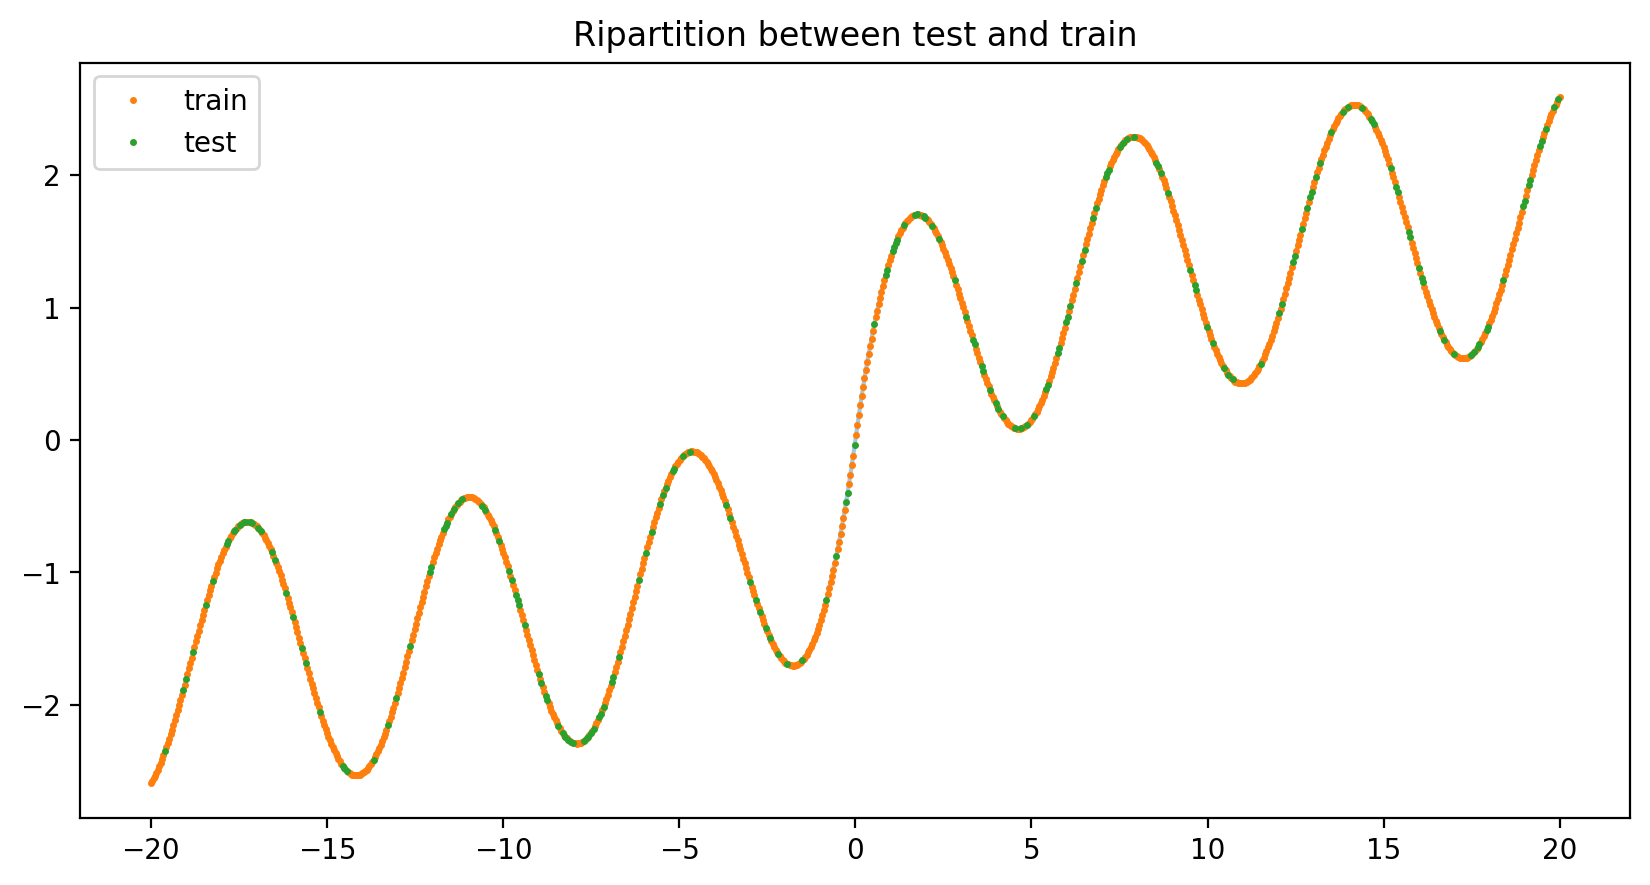

In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(received_signal, signal(received_signal), test_size=0.2, random_state=42)
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(real_signal, signal(real_signal), alpha=0.4)
plt.plot(x_train, y_train, '.', label="train", markersize=3)
plt.plot(x_test, y_test, '.', label="test", markersize=3)
plt.title("Ripartition between test and train")
plt.legend()
plt.show()

# Building a simple MLP
Ok, now we can proceed building an MLP (multi-layer perceptron).

We will use a Sequential model from Keras and we will create a model with just three layers of 10 neurons each and an outlayer of a single neuron.

We will start with a simple model with ReLU activations and see what happens. We can always make it more complex later!

We will add some bells and whistles just to make the experience a bit nicer, but these are not strictly required:

```bash
pip install plot_keras_history keras_ding keras_tqdm
```

Now that we have a model we have to compile it, choosing an optimizer and a loss function!

Since it's a pretty basic model let's start from the basics and use [Stocastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) as optimizer and since our task is a regression task we will use [MSE, the mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error).

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD

def our_first_meta_model(neurons:int=10, optimiser:str="SGD"):
    model = Sequential([
        Input(shape=(1,)), # Do not forget the comma in the tuple!
        Dense(neurons, activation="relu"),
        Dense(neurons, activation="relu"),
        Dense(neurons, activation="relu"),
        Dense(1) # An output layer with a single neuron
    ])
    model.compile(
        optimizer=optimiser,
        loss="MSE"
    )
    return model

In [7]:
def train(model, x_train, y_train, x_test, y_test, **kwargs):
    return model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=10000,
        verbose=False,
        callbacks=[
            Ding(),
            ktqdm(leave_outer=False),
            EarlyStopping("loss", patience=10)
        ],
        **kwargs,
    ).history

In [8]:
# Here we import some callbacks
from keras_ding import Ding
from keras_tqdm import TQDMNotebookCallback as ktqdm
# We also import the EarlyStopping callback, more on this one layer on!
# Basically it will stop the training of our model early it stops improving
from tensorflow.keras.callbacks import EarlyStopping

our_first_linear_MLP = our_first_meta_model()
history = train(our_first_linear_MLP, x_train, y_train, x_test, y_test)

Using TensorFlow backend.


### Visualizing the model training history
To visualize the training history of the model we can use [plot_keras_history](https://github.com/LucaCappelletti94/plot_keras_history). Let's see how the training went!

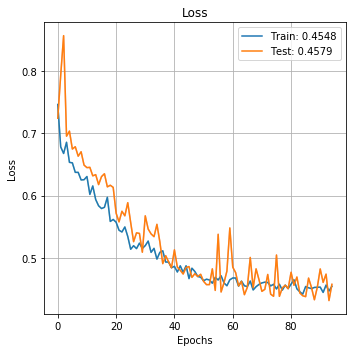

In [9]:
from plot_keras_history import plot_history
plot_history(history)
plt.show()

Wunderbar! It really does seem like the model has learned something! Let's check out the actual predictions now.

In [10]:
def plot_predictions(model, interval, title):
    x = np.linspace(-interval, interval, num=10000)
    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(x, signal(x), label="Actual signal")
    plt.plot(x, model.predict(x), label="Model predictions")
    plt.title(title)
    plt.legend()
    plt.show()

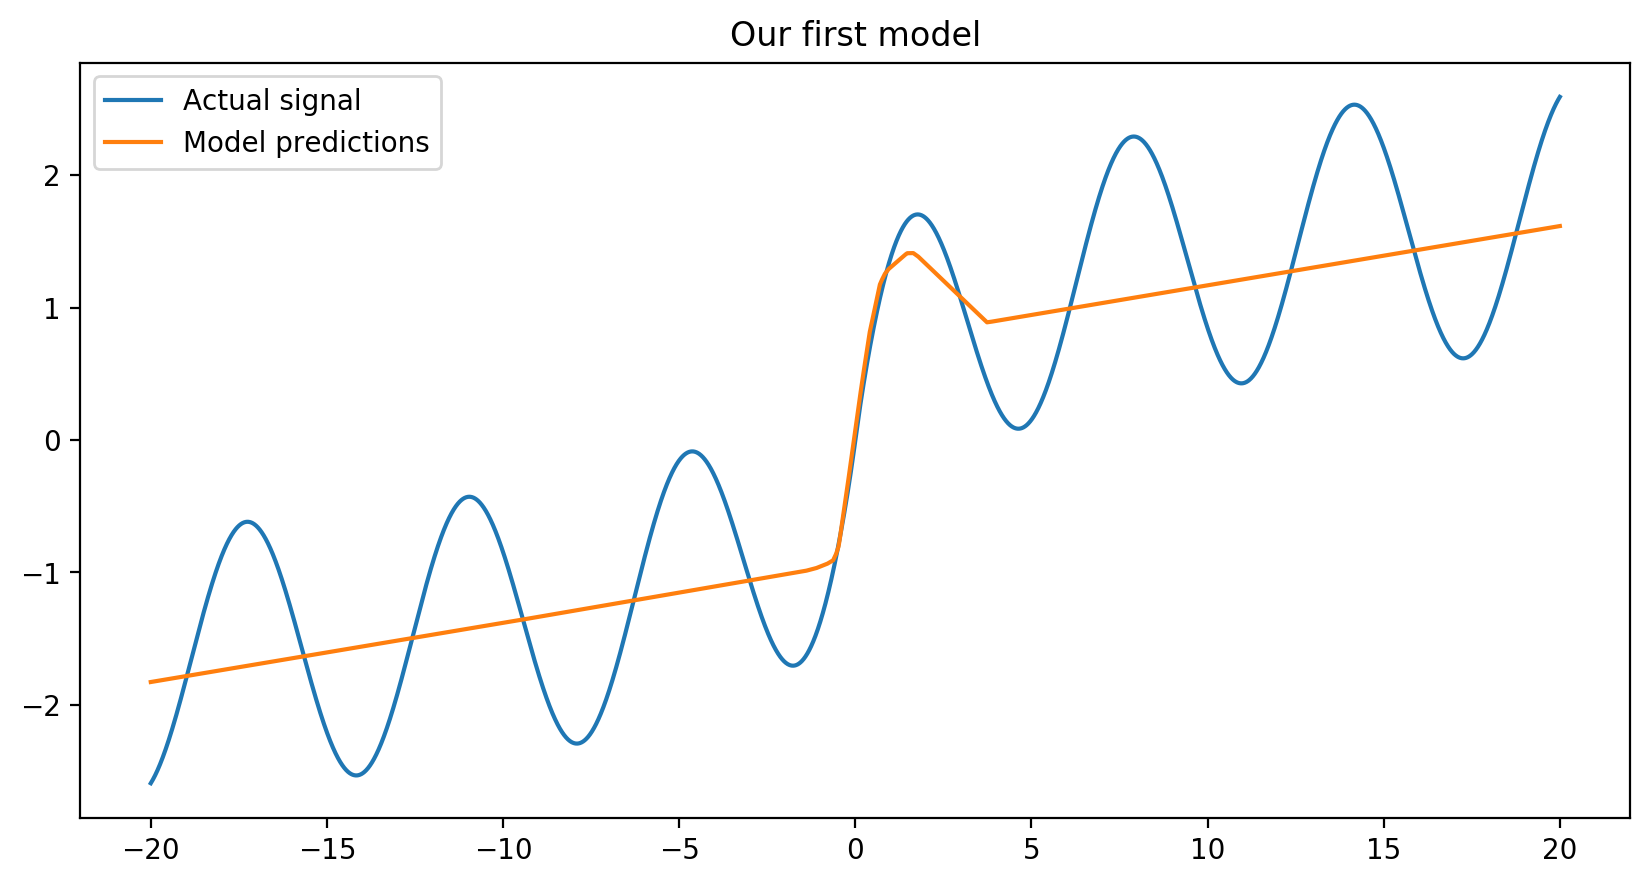

In [11]:
plot_predictions(our_first_linear_MLP, interval, "Our first model")

Uhm, that does not look like a nice prediction! It really looks like a **local minima**.

**Do you have an idea why?**

We can try and buff up our model.

**What would you like to try?**

We could consider for instance to try and increase the number of neurons, from 10 to 100.

In [12]:
our_second_model = our_first_meta_model(100)
history = train(our_second_model, x_train, y_train, x_test, y_test)

As before, we can plot the training history:

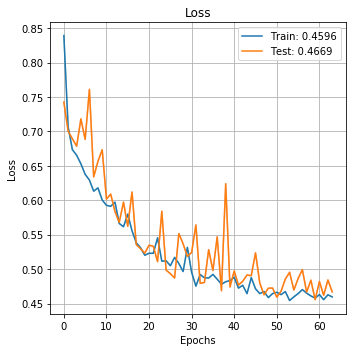

In [13]:
plot_history(history)
plt.show()

That does not look particularly nicer that the previous attempt. Still, let's check the model predictions:

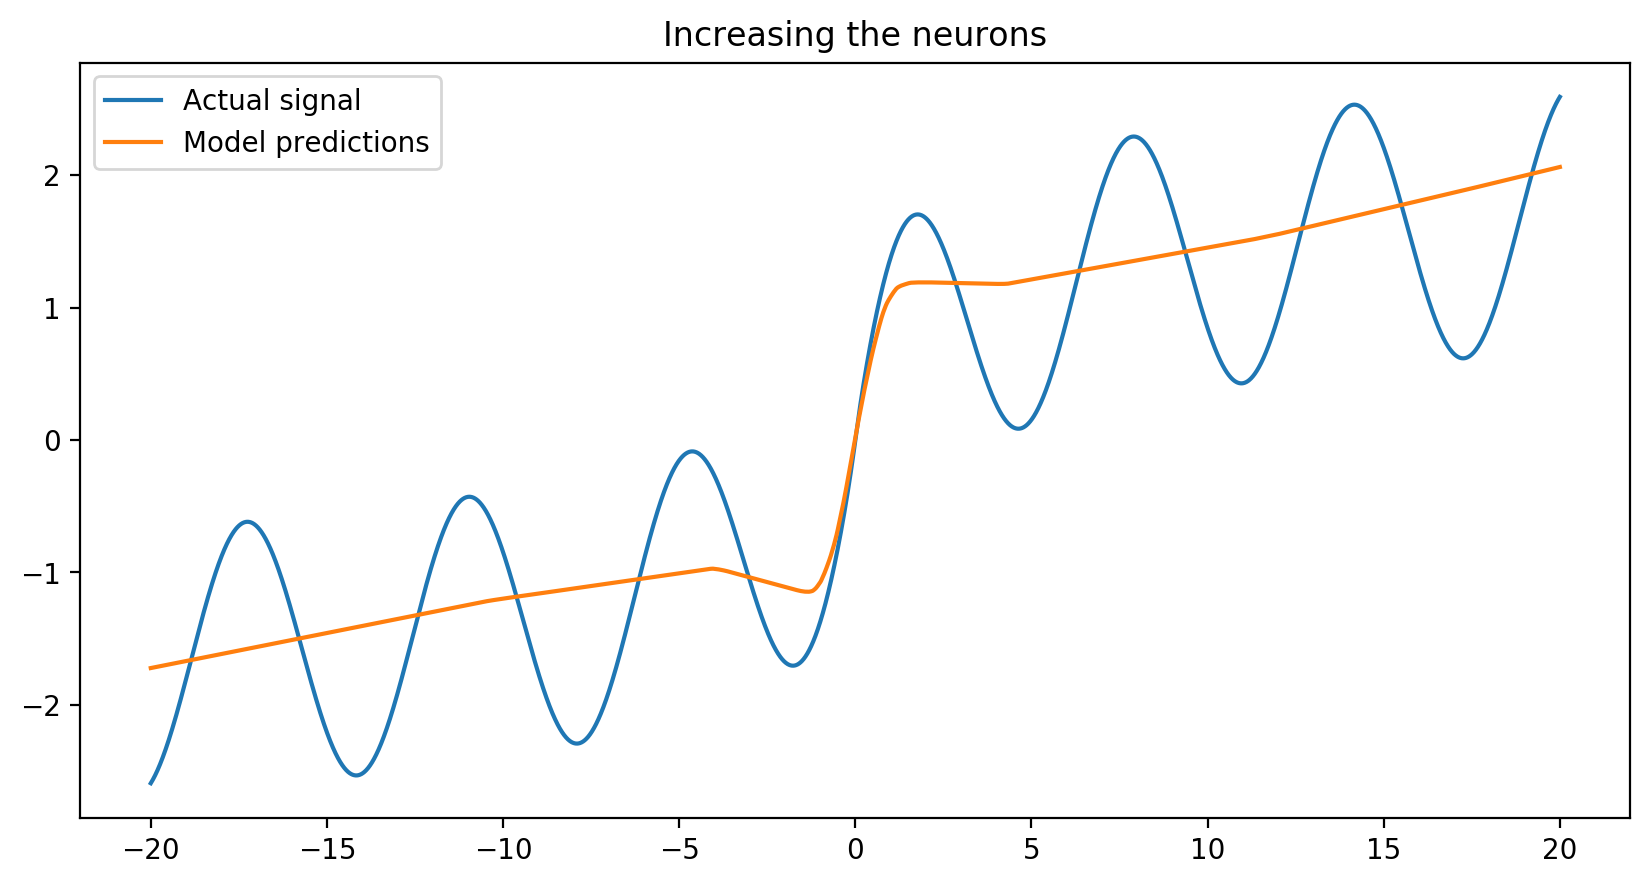

In [14]:
plot_predictions(our_second_model, interval, "Increasing the neurons")

The predictions seem slightly smoother, but nowhere near where they need to be: we are still in the local minima! Another important aspect to consider is which optimizers we should use. [The one we are currently using is SGD, but there are many others](https://keras.io/optimizers/) (check out the documentation!!!).

**Try some of them!**

Here we will proceed using Adam.

In [15]:
model_with_adam = our_first_meta_model(1000, "adam")
history = train(model_with_adam, x_train, y_train, x_test, y_test)

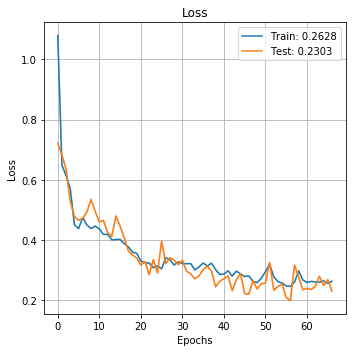

In [16]:
plot_history(history)
plt.show()

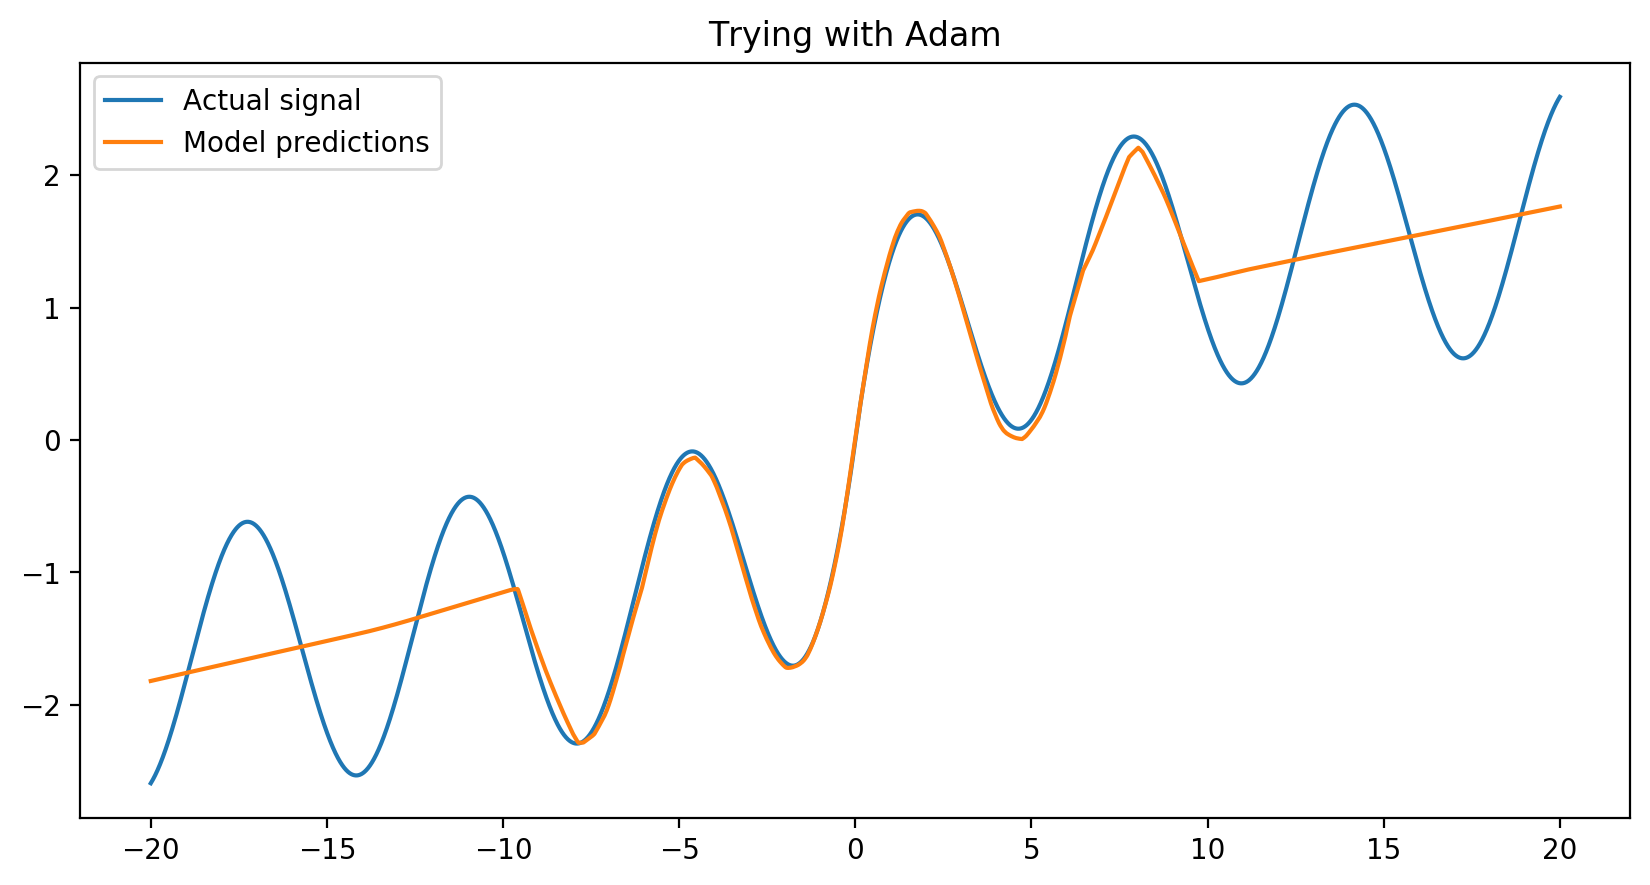

In [17]:
plot_predictions(model_with_adam, interval, "Trying with Adam")

Ok, that's more like it! **In this context** Adam, which is SGD with second order momentum, was the correct optimizer. Now we have to refine the model. We can do that by, for instance, increasing the batch size, so to obtain a more average and smoothed gradient update, though achieving a relatively slower learning process.

It is common to use powers of 2, but there is no particular reason to it.

As a side bonus, **using a bigger batch size makes for faster epochs.**

In [18]:
history = train(model_with_adam, x_train, y_train, x_test, y_test, batch_size=512)

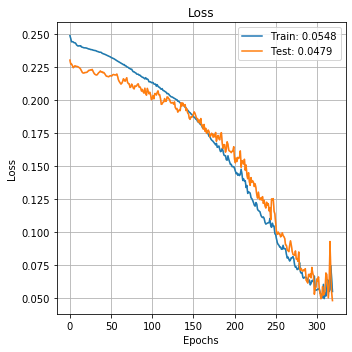

In [19]:
plot_history(history)
plt.show()

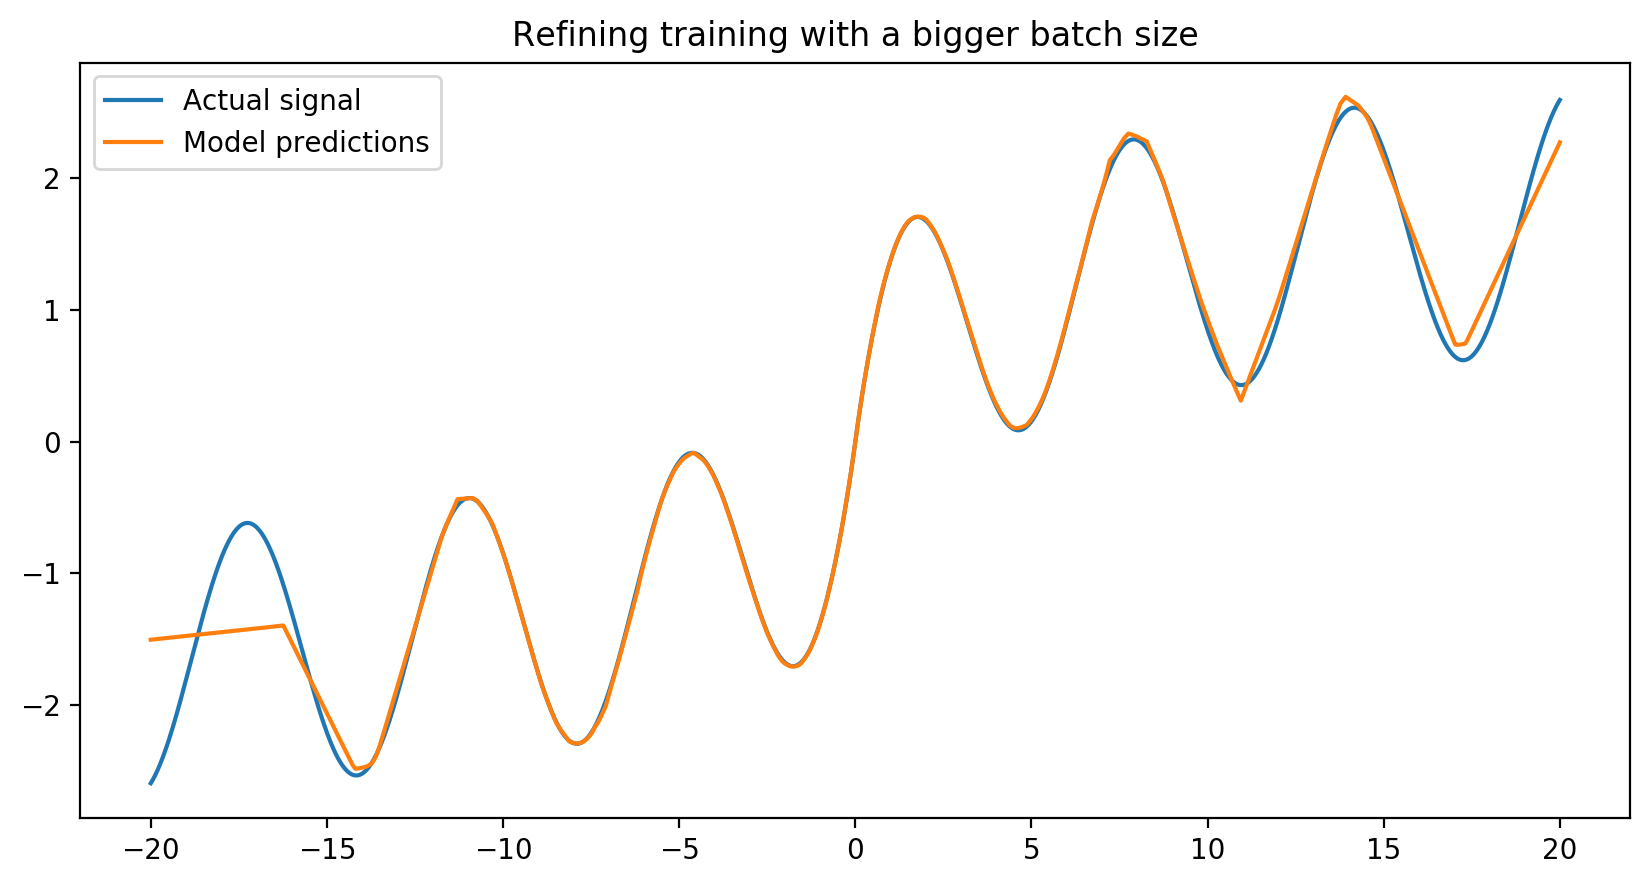

In [20]:
plot_predictions(model_with_adam, interval, "Refining training with a bigger batch size")

## Some duly needed reality checks
Was an MLP really the best way to solve this problem?

It is **always** important, before going neural, to consider the other available models. 

Neural networks, expecially deep neural networks, are models that require a lot of training time and do not have a clearly defined theoretical background. They can be used to solve incredible problems, but for most cases they are overkill and it is always important to **avoid magical thinking**. [The simplest model is often the best one.](https://en.wikipedia.org/wiki/Occam%27s_razor)

Let's consider a decision tree and a random forest and see how they compare to our best model.

In [21]:
# The decision tree
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [22]:
# The Random forest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100)
forest.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Now we can compare the MSE of training and testing of these models. To quickly visualize these results we will be using [pandas](https://pandas.pydata.org/docs/reference/index.html#api) and [barplots](https://github.com/LucaCappelletti94/barplots).

If you don't have them already you can quickly install both of them by running:

```bash
pip install pandas barplots
```

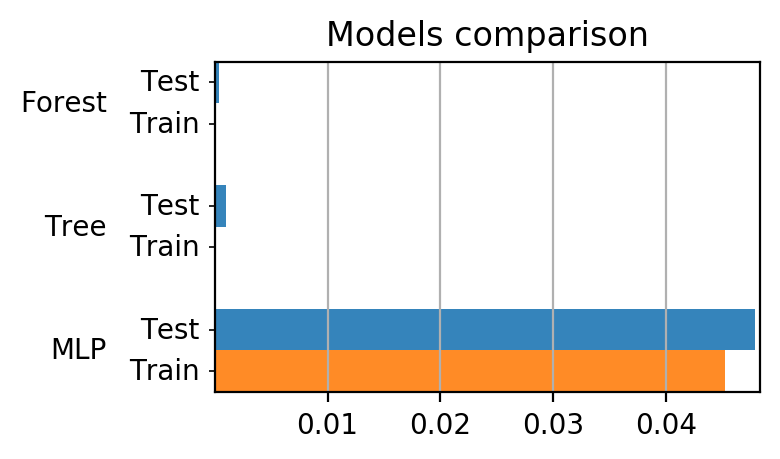

In [23]:
import pandas as pd
from barplots import barplot
from sklearn.metrics import mean_squared_error


reports = []
models = [model_with_adam, tree, forest]
names = ["MLP", "Tree", "Forest"]
for model, name in zip(models, names):
    train_mse = mean_squared_error(y_train, model.predict(x_train.reshape(-1, 1)))
    test_mse = mean_squared_error(y_test, model.predict(x_test.reshape(-1, 1)))
    reports.append({
        "model":name,
        "run_type":"train",
        "MSE": train_mse
    })
    reports.append({
        "model":name,
        "run_type":"test",
        "MSE": test_mse
    })
    
df = pd.DataFrame(reports)
barplot(
    df.set_index(["model", "run_type"]),
    height=4,
    orientation="horizontal",
    show_legend=False,
    title="Models comparison"
)
plt.show()

The MLP is the model with the worse performance! And it was the most complex one to make!

Let's now visualize the predictions of the various models.

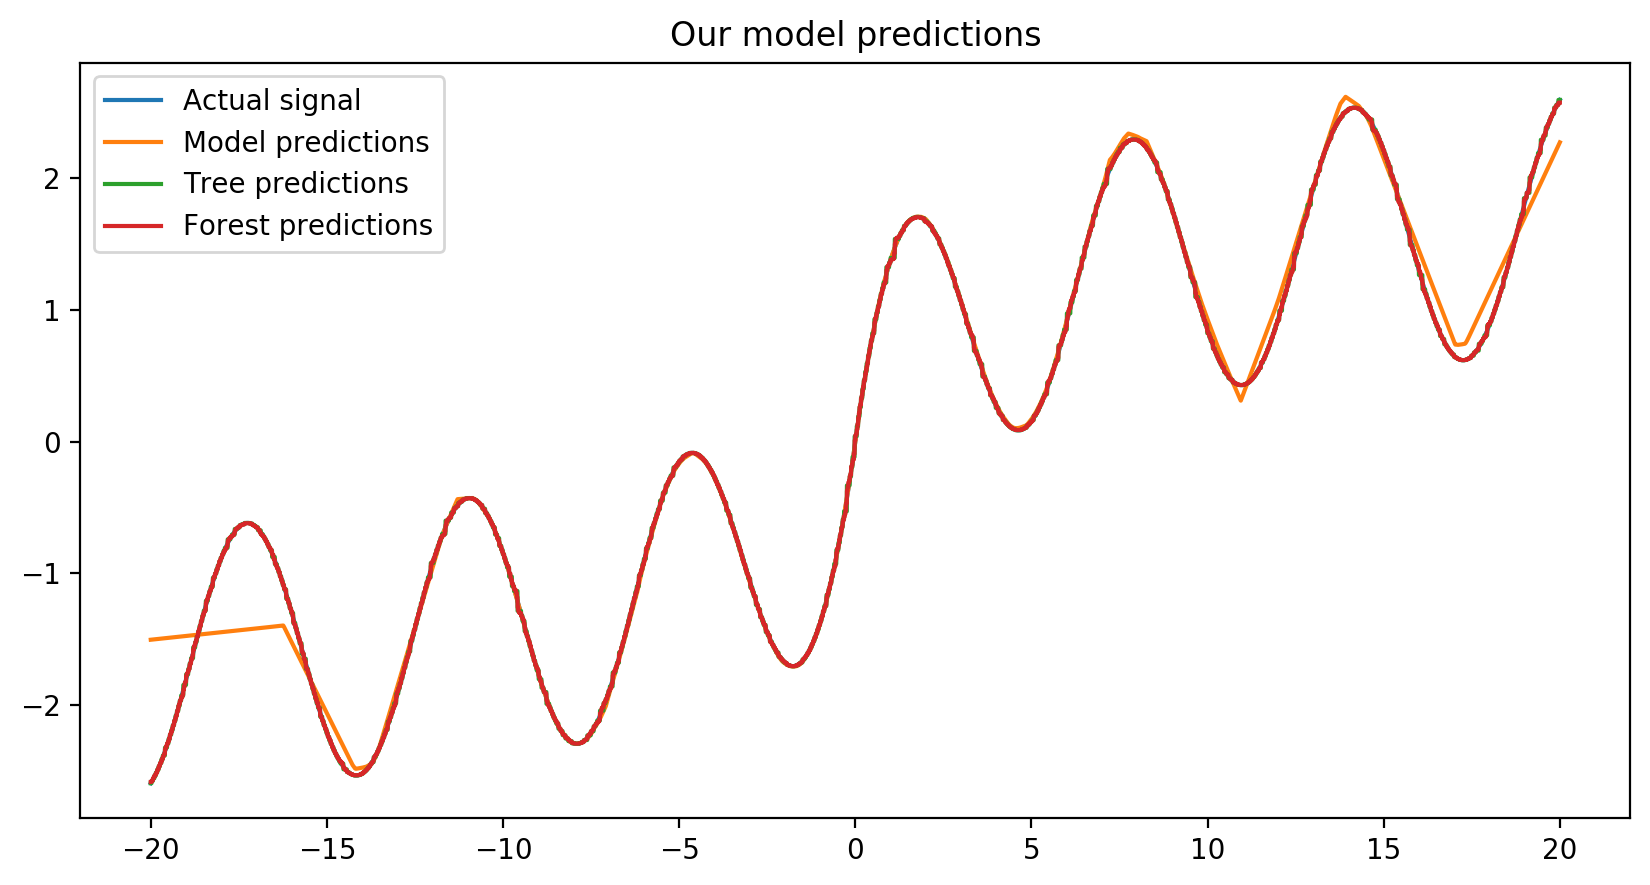

In [24]:
x = np.linspace(-interval, interval, num=10000)
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x, signal(x), label="Actual signal")
plt.plot(x, model_with_adam.predict(x), label="Model predictions")
plt.plot(x, tree.predict(x.reshape(-1, 1)), label="Tree predictions")
plt.plot(x, forest.predict(x.reshape(-1, 1)), label="Forest predictions")

plt.title("Our model predictions")
plt.legend()
plt.show()

It really does seem like the MLP is the model with the worst performance for this task!

But maybe neural network models can generalize better than the others?

Let's see how the model deal with data outside of their training.

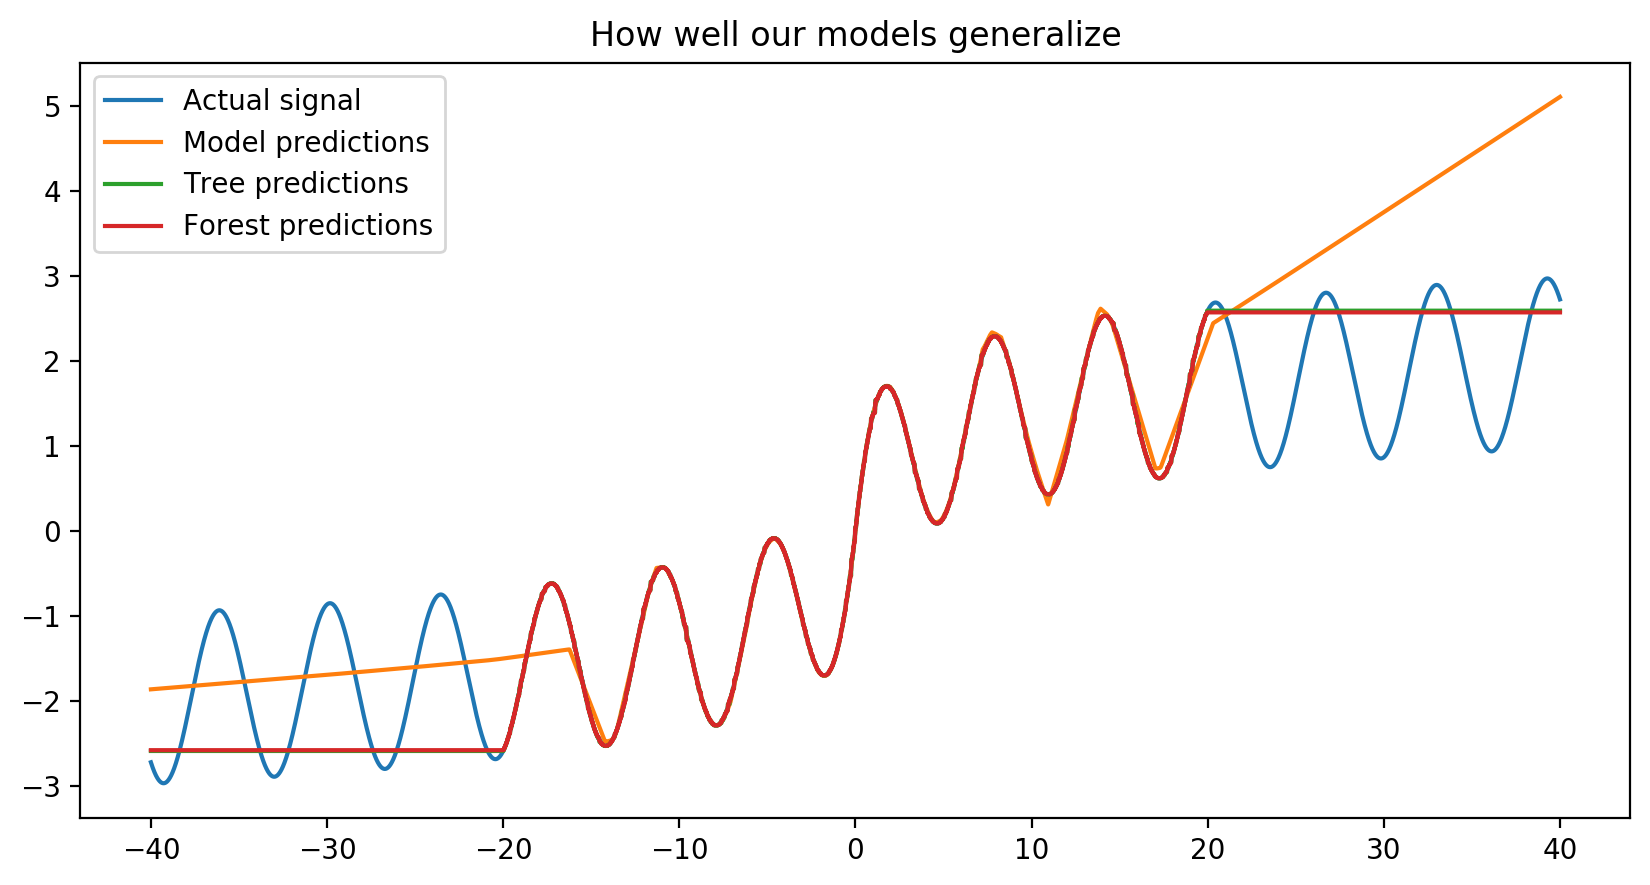

In [25]:
x = np.linspace(-interval*2, interval*2, num=10000)
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x, signal(x), label="Actual signal")
plt.plot(x, model_with_adam.predict(x), label="Model predictions")
plt.plot(x, tree.predict(x.reshape(-1, 1)), label="Tree predictions")
plt.plot(x, forest.predict(x.reshape(-1, 1)), label="Forest predictions")

plt.title("How well our models generalize")
plt.legend()
plt.show()

It is surprising as for us the signal follows a clear pattern, but with so little focused data all our models completely fail to generalize!

On our next lesson, we will take on the task of binary prediction on true epigenomic data. Will the MLPs best the other models on that task?